In [2]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pickle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import time


#Set up a cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))

In [3]:
def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def z_chi(chi):
    return 1/ccl.scale_factor_of_chi(cosmo, chi)-1

def r_3d_rp(rp,z1,z2):
    return ((chi(z1)-chi(z2))**2+(rp)**2)**0.5

def xi_m(r,z):
    return ccl.correlations.correlation_3d(cosmo,a=1/(1+z),r=r,p_of_k_a='delta_matter:delta_matter')

In [4]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

Xi_3d=np.loadtxt('xi3d_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d=np.transpose(Xi_3d)

XI_interp=[]
for iz in range(len(Zlist)):
    XI_interp.append(interpolate.interp1d(R3d, Xi_3d[iz]))

print(np.shape(R3d), ' points for rp and ',np.shape(Zlist), ' for z')


print('minimal distance', round(R3d[0],4), 'Mpc and maximal ', round(R3d[-1],2),'Mpc')
print('minimal redshift', Zlist[0], ' and maximal ', round(Zlist[-1],2))

(40,)  points for rp and  (200,)  for z
minimal distance 0.1 Mpc and maximal  316.23 Mpc
minimal redshift 2.0  and maximal  3.0


In [5]:
# find the best indices with dichotomy

def find_r(x):
    arr=R3d
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

def find_z(x):
    arr=Zlist
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

In [5]:
Xi_3d_bar=np.loadtxt('xi3d_bar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_bar=np.transpose(Xi_3d_bar)

XI_bar_interp=[]
for iz in range(len(Zlist)):
    XI_bar_interp.append(interpolate.interp1d(R3d, Xi_3d_bar[iz]))

In [6]:
Xi_3d_barbar=np.loadtxt('xi3d_barbar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_barbar=np.transpose(Xi_3d_barbar)

XI_barbar_interp=[]
for iz in range(len(Zlist)):
    XI_barbar_interp.append(interpolate.interp1d(R3d, Xi_3d_barbar[iz]))

In [7]:
def xi_rsd(R,z,mu,beta,beta2=None):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    index_z=find_z(z) # find the best z-index for xi
    
    xi_r=XI_interp[index_z]
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_r(R)

    xi_bar_r=XI_bar_interp[index_z]
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*(xi_r(R) - xi_bar_r(R))

    xi_barbar = XI_barbar_interp[index_z]
    xi_4 = 8/35.*beta*beta2*(xi_r(R) + 5/2.*xi_bar_r(R) - 7/2.*xi_barbar(R))
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return xi_0*P_0 + xi_2*P_2 + xi_4*P_4

In [8]:
def omega_m_z(z):
    omega_m0 = 0.315
    return omega_m0*(1+z)**3/(omega_m0*(1+z)**3 + (1-omega_m0))

In [9]:
def mu_rsd(z1,z2,r):
    return (chi(z1)-chi(z2))/r

In [10]:
def wnotLimber_rsd(zmean, Delta_z, rp, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

    
def wnotLimber_rsd_theta(zmean, Delta_z, theta_arcmin, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [11]:
def wnotLimber_rsd_theta_auto(zmean, Delta_z, theta_arcmin, beta_law, bias_law, tracer="gal"): # Here we assume tophat n(z), much faster than the following function
    """
    tracer = gal or lya.
    if gal, beta is dependent on the bias law
    if lya, just a function of z
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            if tracer=="gal":
                beta = beta_law(zmean+z1, bias_law)
                beta2 = beta_law(zmean+z2, bias_law)
            elif tracer == "lya":
                beta = beta_law(zmean+z1)
                beta2 = beta_law(zmean+z2)
            old_output=xi_rsd(r,zmean+z1,mu, beta = beta, beta2 = beta2)
            return old_output*bias_law(zmean+z1)*bias_law(zmean+z2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [12]:
def wnotLimber_rsd_theta_cross(zmean, Delta_z, nz_law, theta_arcmin, beta_law1, beta_law2=None,
                              bias_law1=None, bias_law2=None): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    --Update: including bias makes it very hard to converge...
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=1.8-zmean
    zmax1=3.0-zmean

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd(r,zmean+z1,mu,beta_law1(zmean+z1, bias_law1),beta2=beta_law2(zmean+z2))
            return old_output*nz_law(zmean+z1)*bias_law1(zmean+z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [13]:
# ratio of the linear growth factor at z and at z_p
def D_z_p(z,z_p):
    return ccl.growth_factor(cosmo,1/(1+z))/ccl.growth_factor(cosmo,1/(1+z_p))

# logarithmic growth rate at a given redshift
def f_z(z):
    return ccl.growth_rate(cosmo,1/(1+z))

In [14]:
# now load the linear xi 0, 2, 4 here, construct interpolator as a func of r, z:
fin = np.loadtxt("xi_L_0.txt")
r_Mpc, xi_L_0 = fin[:,0], fin[:,1]

fin = np.loadtxt("xi_L_2.txt")
xi_L_2 = fin[:,1]

fin = np.loadtxt("xi_L_4.txt")
xi_L_4 = fin[:,1]

xi_L_0 = interpolate.interp1d(r_Mpc, xi_L_0)
xi_L_2 = interpolate.interp1d(r_Mpc, xi_L_2)
xi_L_4 = interpolate.interp1d(r_Mpc, xi_L_4)

In [15]:
# linear rsd xi:
def xi_rsd_lin(R,z,mu,beta,beta2=None,z_p=3):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_L_0(R)
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*xi_L_2(R)
    xi_4 = 8/35.*beta*beta2*xi_L_4(R)

    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return (xi_0*P_0 + xi_2*P_2 + xi_4*P_4)*D_z_p(z,z_p)**2

In [16]:
# auto-correlation function
def wnotLimber_rsd_theta_auto_lin(zmean, Delta_z, theta_arcmin, beta_law, bias_law, tracer="gal"): # Here we assume tophat n(z), much faster than the following function
    """
    tracer = gal or lya.
    if gal, beta is dependent on the bias law
    if lya, just a function of z
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            if tracer=="gal":
                beta = beta_law(zmean+z1, bias_law)
                beta2 = beta_law(zmean+z2, bias_law)
            elif tracer == "lya":
                beta = beta_law(zmean+z1)
                beta2 = beta_law(zmean+z2)
            old_output=xi_rsd_lin(r,zmean+z1,mu, beta = beta, beta2 = beta2)
            return old_output*bias_law(zmean+z1)*bias_law(zmean+z2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


# cross-correlation function
def wnotLimber_rsd_theta_cross_lin(zmean, Delta_z, nz_law, theta_arcmin, beta_law1, beta_law2=None,
                              bias_law1=None, bias_law2=None, zlim=[1.0,3.0]): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    This is for linear power spectrum!!
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=zlim[0]
    zmax1=zlim[1]

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd_lin(r,z1,mu,beta_law1(z1, bias_law1),beta2=beta_law2(zmean+z2))
            return old_output*nz_law(z1)*bias_law1(z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

# cross-correlation function
def wnotLimber_rsd_theta_cross_tophats_lin(zmean, Delta_z, theta_arcmin, beta_law1, beta_law2=None,
                              bias_law1=None, bias_law2=None): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    This is for linear power spectrum!!
    This is for cross-correlations in tophat bins!!
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd_lin(r,zmean+z1,mu,beta_law1(zmean+z1, bias_law1),beta2=beta_law2(zmean+z2))
            return 1/Delta_z*old_output*bias_law1(zmean+z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [17]:
# Galaxy bias model:
data=np.loadtxt('../bias_dc2.txt')
Z_bias,bias_model=data[:,0],data[:,1]
bias_law_gal=interpolate.interp1d(Z_bias,bias_model,bounds_error=False,fill_value="extrapolate")

# Lya bias model:
def bias_law_lya(z):
    alpha = 2.9
    bias_zref = -0.1352
    zref = 2.4
    return bias_zref * ((1 + z)/(1 + zref))**alpha

def bias_law_lya_mod(z):
    """
    Including an overall factor to fit
    the lya auto-correlation
    """
    alpha = 2.9
    bias_zref = -0.1352
    zref = 2.4
    factor = 0.9
    return bias_zref * ((1 + z)/(1 + zref))**alpha * factor

# Lya beta model (need to fit quadratic)
#fin = np.loadtxt("beta_lya_dr16.txt")
#x,y = fin[:,0], fin[:,1]
#p = np.polyfit(x,y,2)
#beta_law_lya = np.poly1d(p)

def beta_law_gal(z, bias_law):
    return omega_m_z(z)**0.55/bias_law(z)

# wss, fixed beta
def beta_law_lya(z):
    return 1.53

In [14]:
colors = plt.cm.viridis(np.linspace(0,1,20))

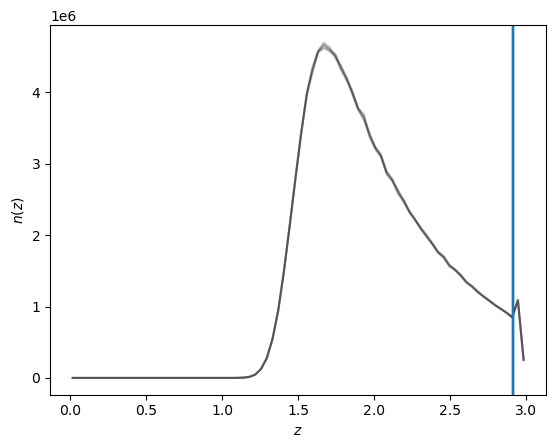

In [19]:
# load n(z) of galaxies here: # load SRD redshifts
root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
#! if downloaded from github, use root="data/"

nz_avg = 0
for ii in range(10):
    fname = root + f"run-{ii}/catalogue/nz-unknown-SRD_nz-zmin-0-zmax-3.txt"
    fin = np.loadtxt(fname)
    plt.plot(fin[:,0],fin[:,1], alpha=0.1,color='k')
    nz_avg += fin[:,1]/10

    plt.axvline(2.91) # results above this redshift maybe weird
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
# let's get interpolation function
dz = fin[1,0]-fin[0,0]
nz_avg = nz_avg/sum(nz_avg)/dz
nz_zsamp = fin[:,0]
nz_gal_law = interpolate.interp1d(nz_zsamp,nz_avg,fill_value=0,bounds_error=False)

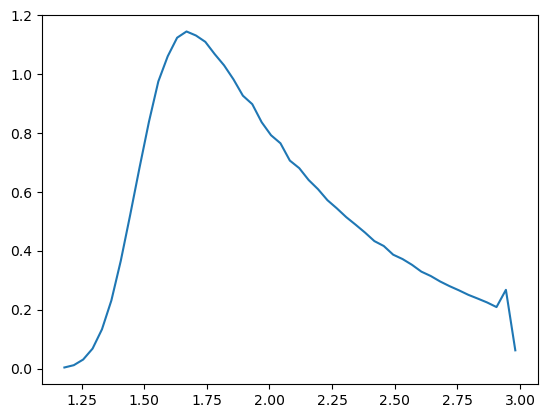

In [20]:
plt.plot(nz_zsamp[nz_avg>0][3:],nz_avg[nz_avg>0][3:])

In [52]:
np.linspace(1,2,21)

array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ])

# Data

In [8]:
def grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64, reverse_order=False):
    mean = np.mean(fin,axis=0)
    if reverse_order==False:
        d1=ntheta
        d2=Nbins
    else:
        d1=Nbins
        d2=ntheta
    mean = mean.reshape((d1,d2))
    std = np.std(fin,axis=0)*np.sqrt(njn)
    std = std.reshape((d1,d2))
    return mean, std

In [15]:
Nbins=20 # we will also run a 10 bin version (in hope of getting to smaller angular scales)
theta_min=1
theta_max=50
ntheta=15

theta_1_50_binedge = np.logspace(np.log10(theta_min),np.log10(theta_max),ntheta+1)
theta_1_50_bincen = (theta_1_50_binedge[1:] + theta_1_50_binedge[:-1])/2.
redshift_binedges = np.linspace(2,3,Nbins+1)
redshift_bincen = (redshift_binedges[1:] + redshift_binedges[:-1])/2.

dTheta_1_50=np.array([theta_1_50_binedge[i+1]-theta_1_50_binedge[i] for i in range(ntheta)])

In [105]:
# load the measurements below:
wss_thetasplit={}
wpp_thetasplit={}
wsp_thetasplit={}
wsp_zbins_thetasplit={}

#! if downloaded from github, use root="data/"

for ii in range(10):
    root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
    root += f"run-{ii}/yaw-20bin-SRD_nz/"
    fin = np.loadtxt(root + f"w_ss-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wss_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    fin = np.loadtxt(root + f"w_pp-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wpp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    fin = np.loadtxt(root + f"w_sp-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wsp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)
    
    fin = np.loadtxt(root + f"w_sp-zbins-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wsp_zbins_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64, reverse_order=True)

In [106]:
# compute mock average
wss_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wpp_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wsp_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wsp_zbins_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))

holder = np.zeros((10, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))

for ii in range(10):
    holder[ii] = wss_thetasplit[ii][0]
wss_thetasplit_avg[0] = np.mean(holder,axis=0)
wss_thetasplit_avg[1] = np.std(holder,axis=0)
    
for ii in range(10):
    holder[ii] = wpp_thetasplit[ii][0]
wpp_thetasplit_avg[0] = np.mean(holder,axis=0)
wpp_thetasplit_avg[1] = np.std(holder,axis=0)

for ii in range(10):
    holder[ii] = wsp_thetasplit[ii][0]
wsp_thetasplit_avg[0] = np.mean(holder,axis=0)
wsp_thetasplit_avg[1] = np.std(holder,axis=0)

for ii in range(10):
    holder[ii] = wsp_zbins_thetasplit[ii][0].T
wsp_zbins_thetasplit_avg[0] = np.mean(holder,axis=0)
wsp_zbins_thetasplit_avg[1] = np.std(holder,axis=0)

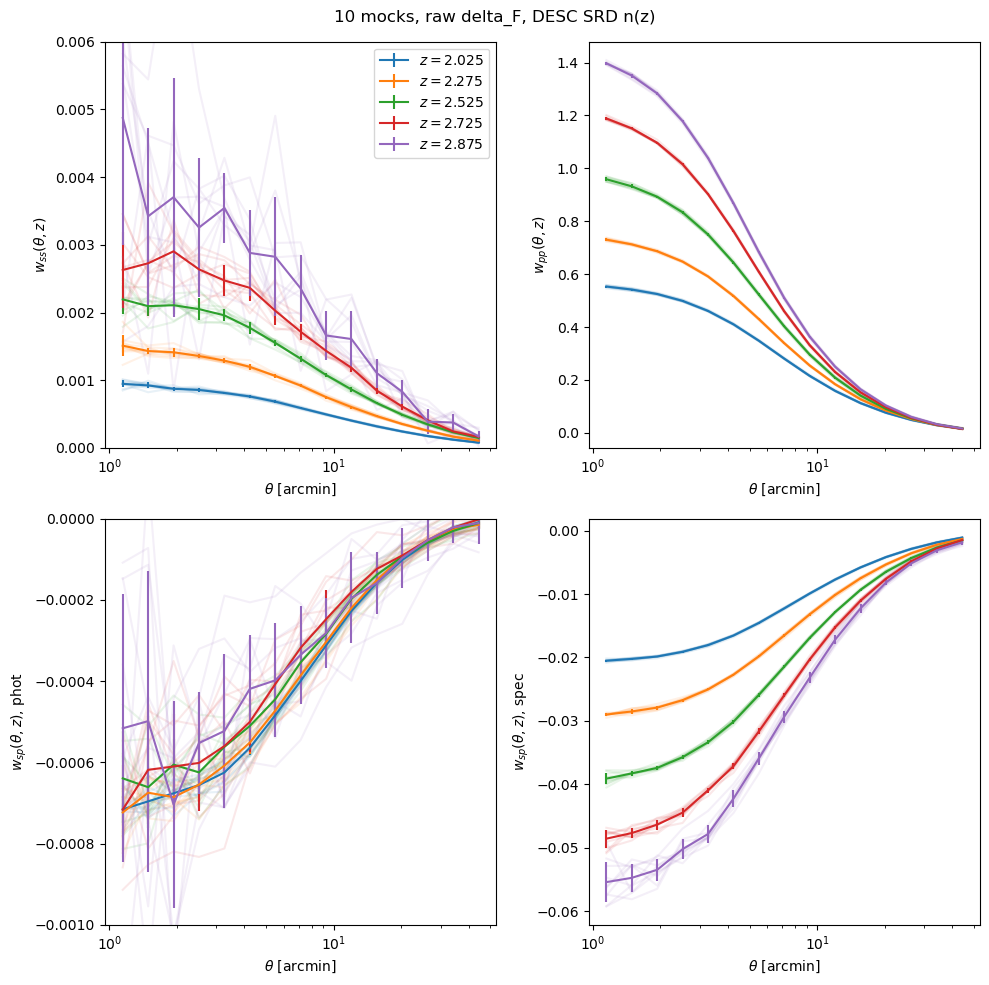

In [107]:
# show results:
show_ind = [0, 5, 10, 14, 17]

fig,axarr=plt.subplots(2,2,figsize=[10,10])

plt.suptitle("10 mocks, raw delta_F, DESC SRD n(z)")

plt.sca(axarr[0,0])
for kk, ind in enumerate(show_ind):
    label=f"$z = {redshift_bincen[ind]}$"
    plt.errorbar(theta_1_50_bincen, wss_thetasplit_avg[0][:,ind],yerr=wss_thetasplit_avg[1][:,ind], color=f'C{kk}',
                label=label)
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wss_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.ylim([0,0.006])
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{ss}(\\theta, z)$")
plt.legend()

plt.sca(axarr[0,1])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wpp_thetasplit_avg[0][:,ind],yerr=wpp_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wpp_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{pp}(\\theta, z)$")


plt.sca(axarr[1,0])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wsp_thetasplit_avg[0][:,ind],yerr=wsp_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wsp_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, phot")
plt.ylim([-0.001,0])

plt.sca(axarr[1,1])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wsp_zbins_thetasplit_avg[0][:,ind],yerr=wsp_zbins_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, (wsp_zbins_thetasplit[ii][0].T)[:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, spec")
#plt.ylim([-0.001,0])

plt.tight_layout()

In [ ]:
# SNR for the w_sp

# Comparison with theory

In [25]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [26]:
# let's compute the auto-correlations for the galaxies and the lya, compare to the data measurements:
Dz=0.05

Ntheta=15

beta_law = beta_law_lya # this is for lya
bias_law = bias_law_lya

Wss_dz05_rsd_lin=np.zeros((Ntheta,Nbins))

for itheta in range(Ntheta):
    #print(itheta)
    for kk, ind in enumerate(np.arange(Nbins)):
        zmean = redshift_bincen[ind]
        Wss_dz05_rsd_lin[itheta, kk] = wnotLimber_rsd_theta_auto_lin(zmean, Dz, 
                                                theta_1_50_bincen[itheta], beta_law, bias_law, tracer="lya")

In [28]:
# let's compute the auto-correlations for the galaxies and the lya, compare to the data measurements:
# this is for galaxies

beta_law = beta_law_gal #this is for galaxy
bias_law = bias_law_gal

Wpp_dz05_rsd_lin=np.zeros((Ntheta,len(show_ind)))

for itheta in range(Ntheta):
    #print(itheta)
    for kk, ind in enumerate(show_ind):
        zmean = redshift_bincen[ind]
        Wpp_dz05_rsd_lin[itheta, kk] = wnotLimber_rsd_theta_auto_lin(zmean, Dz, 
                                         theta_1_50_bincen[itheta], beta_law, bias_law, tracer="gal")

In [29]:
nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta150_dz05_rsd_lin=np.zeros((ntheta,len(show_ind)))

for itheta in range(ntheta):
    #print(itheta)
    for kk, ind in enumerate(show_ind):
        theta = theta_1_50_bincen[itheta]
        zmean = redshift_bincen[ind]
        Wsp_theta150_dz05_rsd_lin[itheta, kk] = wnotLimber_rsd_theta_cross_lin(zmean, Dz, nz_law, theta, 
                                                    beta_law1, 
                                                    beta_law2=beta_law2, bias_law1=bias_law1, 
                                                    bias_law2=bias_law2)

In [95]:
#nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wspz_theta150_dz05_rsd_lin=np.zeros((ntheta,Nbins))

for itheta in range(ntheta):
    #print(itheta)
    for kk, ind in enumerate(np.arange(Nbins)):
        theta = theta_1_50_bincen[itheta]
        zmean = redshift_bincen[ind]
        Wspz_theta150_dz05_rsd_lin[itheta, kk] = wnotLimber_rsd_theta_cross_tophats_lin(zmean, Dz, theta, beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, 
                                                       bias_law2=bias_law2)

Text(0.5, 1.0, '$\\Delta z = 0.05$, $\\beta(z) = 1.53$, $b(z) = -0.1352((1+z)/(1+2.4))^{2.9}$')

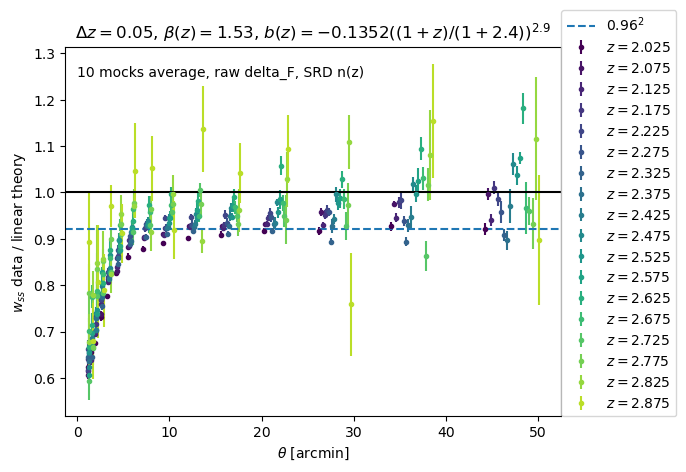

In [29]:
for kk, ind in enumerate(np.arange(Nbins-2)):
    y = wss_thetasplit_avg[0][:,ind]/Wss_dz05_rsd_lin[:,kk]
    dy = wss_thetasplit_avg[1][:,ind]/Wss_dz05_rsd_lin[:,kk]
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
plt.axhline(0.96**2,ls='--',label="$0.96^2$")
plt.axhline(1, color='k')
plt.ylabel("$w_{ss}$ data / linear theory")
plt.text(0,1.25,"10 mocks average, raw delta_F, SRD n(z)")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, $\\beta(z) = 1.53$, $b(z) = -0.1352((1+z)/(1+2.4))^{2.9}$")

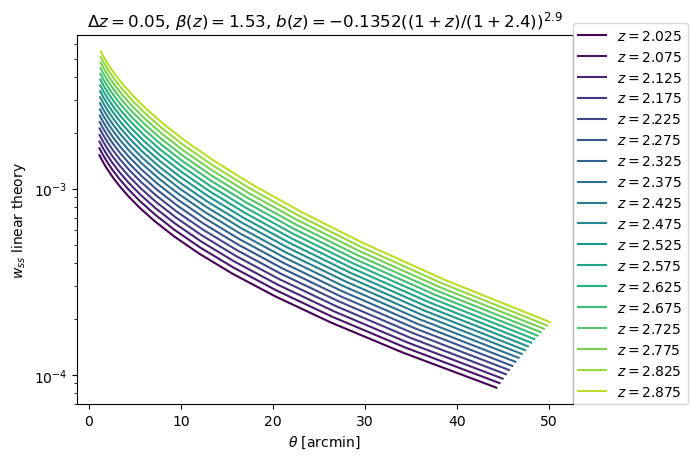

In [34]:
# plot sepatae
for kk, ind in enumerate(np.arange(Nbins-2)):
    y = Wss_dz05_rsd_lin[:,kk]
    plt.plot(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
#plt.axhline(0.96**2,ls='--',label="$0.96^2$")
#plt.axhline(1, color='k')
plt.ylabel("$w_{ss}$ linear theory")
#plt.text(0,1.25,"10 mocks average, raw delta_F, SRD n(z)")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, $\\beta(z) = 1.53$, $b(z) = -0.1352((1+z)/(1+2.4))^{2.9}$")
plt.yscale("log")

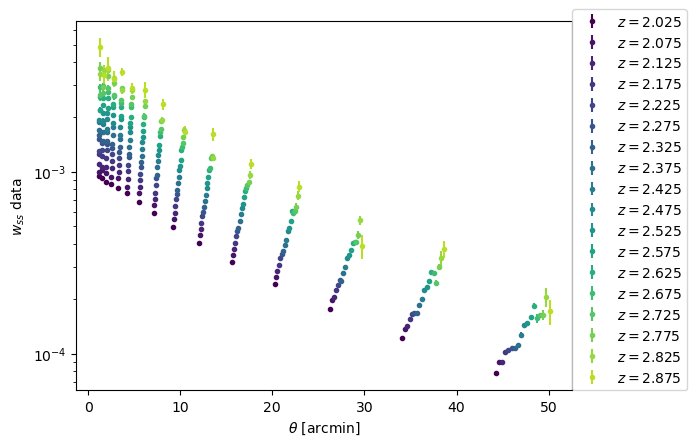

In [171]:
# plot sepatae
for kk, ind in enumerate(np.arange(Nbins-2)):
    y = wss_thetasplit_avg[0][:,ind]
    dy = wss_thetasplit_avg[1][:,ind]
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
#plt.axhline(0.96**2,ls='--',label="$0.96^2$")
#plt.axhline(1, color='k')
plt.ylabel("$w_{ss}$ data")
#plt.text(0,1.25,"10 mocks average, raw delta_F, SRD n(z)")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
#plt.title("$\\Delta z = 0.05$, $\\beta(z) = 1.53$, $b(z) = -0.1352((1+z)/(1+2.4))^{2.9}$")
plt.yscale("log")

(0.5, 1.4)

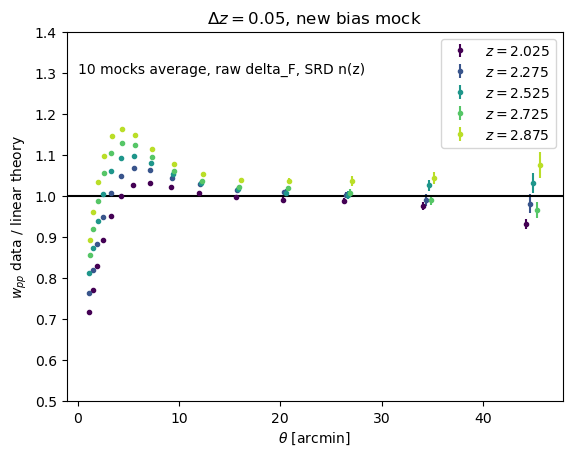

In [36]:
for kk, ind in enumerate(show_ind):
    y =  wpp_thetasplit_avg[0][:,ind]/Wpp_dz05_rsd_lin[:,kk]
    dy = wpp_thetasplit_avg[1][:,ind]/Wpp_dz05_rsd_lin[:,kk]
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
    #y = wpp_theta_split_mean[:,useind[ii]]/Wpp_dz05_rsd_nl[:,ii]
    #plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, y, yerr=dy, fmt='*', color=colors[useind[ii]],alpha=0.3)
    #dy = wpp_theta_split_std[:,useind[ii]]/Wpp_dz05_rsd_nl[:,ii]
    
plt.text(0,1.3,"10 mocks average, raw delta_F, SRD n(z)")
plt.axhline(1, color='k')
plt.ylabel("$w_{pp}$ data / linear theory")
#plt.ylim([0,0.005])
#plt.xscale("log")
#plt.errorbar([-1],[1],yerr=[1],fmt='*', color='grey', alpha=0.3, label="NL theory")
plt.legend()
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, new bias mock")
#plt.xlim([0,50])
plt.ylim([0.5,1.4])

(0.0, 2.0)

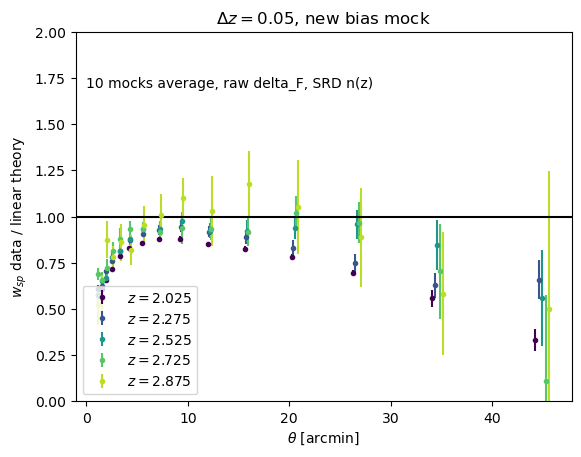

In [37]:
for kk, ind in enumerate(show_ind):
    y = wsp_thetasplit_avg[0][:,ind]/Wsp_theta150_dz05_rsd_lin[:,kk]
    dy = abs(wsp_thetasplit_avg[1][:,ind]/Wsp_theta150_dz05_rsd_lin[:,kk])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
plt.axhline(1, color='k')
plt.ylabel("$w_{sp}$ data / linear theory")
plt.legend(loc="lower left")
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, new bias mock")
plt.text(0,1.7,"10 mocks average, raw delta_F, SRD n(z)")
plt.ylim([0,2])

Text(0.5, 1.0, '$\\Delta z = 0.05$, top-hat bins')

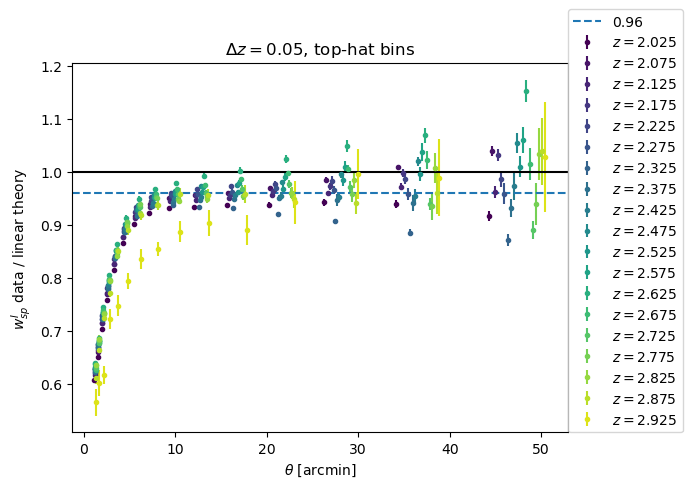

In [101]:
#for kk, ind in enumerate(show_ind):
for kk, ind in enumerate(np.arange(Nbins-1)):
    #plt.plot(Theta_10_30_bincen, , color=colors[useind[ii]])
    y = wsp_zbins_thetasplit_avg[0][:,ind]/Wspz_theta150_dz05_rsd_lin[:,kk]
    dy = abs(wsp_zbins_thetasplit_avg[1][:,ind]/Wspz_theta150_dz05_rsd_lin[:,kk])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
plt.axhline(1, color='k')
plt.axhline(0.96,ls='--',label="0.96")
plt.ylabel("$w_{sp}^I$ data / linear theory")
#plt.ylim([0,0.005])
#plt.xscale("log")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, top-hat bins")

# checks on w_sp (phot)

In [39]:
def w_theta_comb(w_theta_z, theta_edges, theta_weight_func, theta_weight_norm=True):
    """
    w_theta_z: 1D or 2D array of w_theta. 1D = fixed z; 2D allows different z values along axis=1.
    theta_egdes: bin edges to evaluate theta (typically lognormal bins)
    theta_weight_func: computes the weights of each theta
    theta_weight_norm: boolean to determine whether normalize the weight function, default is true.
    """
    
    Ntheta=len(theta_edges)-1
    theta_bincen = (theta_edges[1:] + theta_edges[:-1])/2.
    dtheta=np.array([theta_edges[i+1]-theta_edges[i] for i in range(Ntheta)])

    weights = theta_weight_func(theta_bincen)
    
    if theta_weight_norm == True:
        norm = sum(weights*dtheta)
        weights = weights/norm
        
    if len(w_theta_z.shape) == 1:
        w_comb = sum(w_theta_z*weights*dtheta)
        
    else:
        # make sure w_theta_z has theta variation along axis = 0!
        w_comb = np.sum(w_theta_z*weights[:,None]*dtheta[:,None],axis=0)
    
    return w_comb

def theta_weight_func(theta):
    return np.ones(len(theta))

In [40]:
nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta150_dz05_rsd_lin_f=np.zeros((ntheta,Nbins))

for itheta in range(ntheta):
    #print(itheta)
    for kk, ind in enumerate(np.arange(Nbins)):
        theta = theta_1_50_bincen[itheta]
        zmean = redshift_bincen[ind]
        Wsp_theta150_dz05_rsd_lin_f[itheta, kk] = wnotLimber_rsd_theta_cross_lin(zmean, Dz, nz_law, theta, 
                                                    beta_law1, 
                                                    beta_law2=beta_law2, bias_law1=bias_law1, 
                                                    bias_law2=bias_law2)

/tmp/ipykernel_1152268/1479143881.py:69: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


In [41]:
# combine theta on large scales, compare data with theory:
mask_ind = np.where(theta_1_50_bincen>23)[0][0]
wsp_comb = np.zeros((20,10))
for ii in range(10):
    w_theta_z = wsp_thetasplit[ii][0][mask_ind:,:]
    wsp_comb[:,ii] = w_theta_comb(w_theta_z, theta_1_50_binedge[mask_ind:], theta_weight_func)

wsp_comb_avg = np.c_[np.mean(wsp_comb,axis=1), np.std(wsp_comb,axis=1)]
wsp_comb_linth = w_theta_comb(Wsp_theta150_dz05_rsd_lin_f[mask_ind:,:], 
                              theta_1_50_binedge[mask_ind:], theta_weight_func)

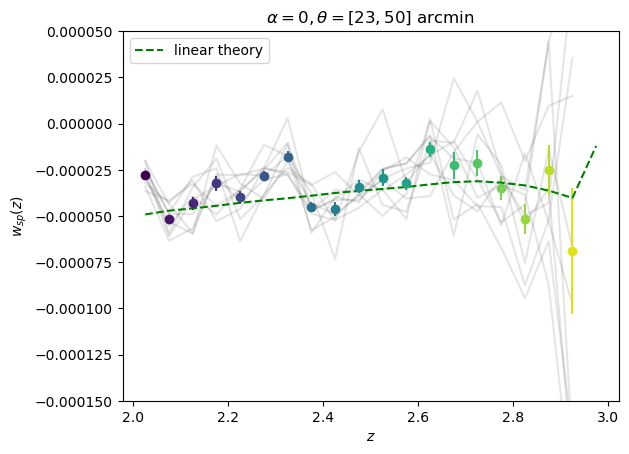

In [47]:
for ii in range(10):
    plt.plot(redshift_bincen, wsp_comb[:,ii], alpha=0.1, color='k')
for jj in range(19):
    plt.errorbar(redshift_bincen[jj], wsp_comb_avg[jj,0], yerr=wsp_comb_avg[jj,1]/np.sqrt(10), 
                 fmt='o', color=colors[jj])
plt.plot(redshift_bincen,wsp_comb_linth,color='green', ls='--',label="linear theory")
plt.xlabel("$z$")
plt.ylabel("$w_{sp}(z)$")
plt.title("$\\alpha=0, \\theta=[23,50]$ arcmin")
plt.ylim([-0.00015, 0.00005])
plt.legend()

Plot a few more low z data vs theory:

(0.0, 2.0)

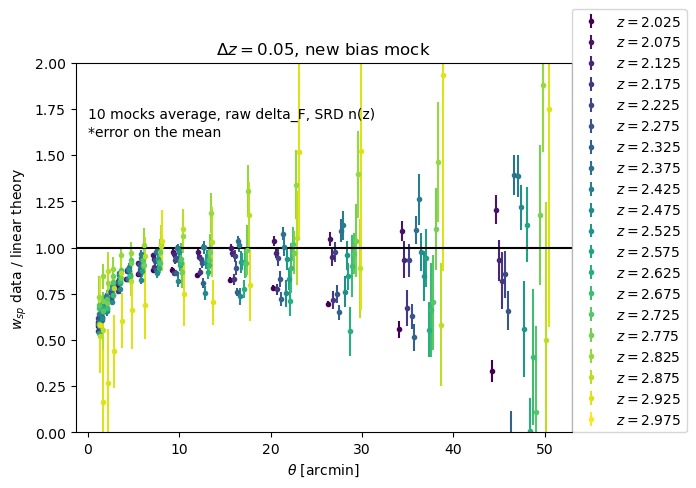

In [43]:
for kk in range(20):
    y = wsp_thetasplit_avg[0][:,kk]/Wsp_theta150_dz05_rsd_lin_f[:,kk]
    dy = abs(wsp_thetasplit_avg[1][:,kk]/Wsp_theta150_dz05_rsd_lin_f[:,kk])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[kk],
                label=f"$z={redshift_bincen[kk]}$")
plt.axhline(1, color='k')
plt.ylabel("$w_{sp}$ data / linear theory")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, new bias mock")
plt.text(0,1.7,"10 mocks average, raw delta_F, SRD n(z)")
plt.text(0,1.6,"*error on the mean")
plt.ylim([0,2])

(2e-05, 0.002)

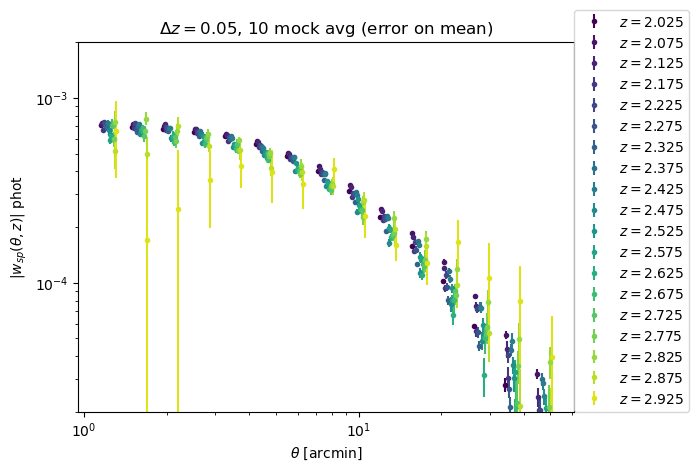

In [81]:
# check the theory versus data:
for kk in range(19):
    y = abs(wsp_thetasplit_avg[0][:,kk])#/Wsp_theta150_dz05_rsd_lin_f[:,kk]
    dy = abs(wsp_thetasplit_avg[1][:,kk])#/Wsp_theta150_dz05_rsd_lin_f[:,kk])
    y2 = abs(Wsp_theta150_dz05_rsd_lin_f[:,kk])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[kk],
                label=f"$z={redshift_bincen[kk]}$")
    #plt.loglog(theta_1_50_bincen + kk*0.03*dTheta_1_50, y2, color=colors[kk],label=f"$z={redshift_bincen[kk]}$")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, 10 mock avg (error on mean)")
plt.ylabel("$|w_{sp}(\\theta, z)|$ phot")
plt.ylim([2e-5,2e-3])

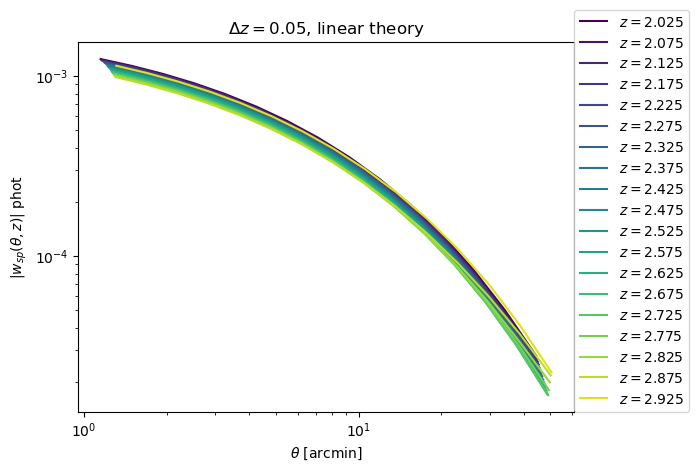

In [75]:
# check the theory versus data:
#fig,axarr=plt.subplots(1,3,figsize=[10,4],sharex=True, sharey=True)
for kk in range(19):
    y = abs(wsp_thetasplit_avg[0][:,kk])#/Wsp_theta150_dz05_rsd_lin_f[:,kk]
    dy = abs(wsp_thetasplit_avg[1][:,kk])#/Wsp_theta150_dz05_rsd_lin_f[:,kk])
    y2 = abs(Wsp_theta150_dz05_rsd_lin_f[:,kk])
    #plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=f'C{kk}',
    #            label=f"$z={redshift_bincen[kk]}$")
    plt.loglog(theta_1_50_bincen + kk*0.03*dTheta_1_50, y2, color=colors[kk],label=f"$z={redshift_bincen[kk]}$")
    plt.legend(loc=[1,0])
    plt.xlabel("$\\theta$ [arcmin]")
    plt.title("$\\Delta z = 0.05$, linear theory")
    plt.ylabel("$|w_{sp}(\\theta, z)|$ phot")

# Sanity check: spec x phot galaxy correlation
spec: downsampled galaxy to 10% of the original sample to avoid spending too long in measurements, SNR is good enough for this

In [29]:
# check mock 0:
Nbins=20 # we will also run a 10 bin version (in hope of getting to smaller angular scales)
theta_min=1
theta_max=50
ntheta=15

wgsp_thetasplit={}

#root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
#! if downloaded from github, use root="data/"

for ii in range(10):
    root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
    root += f"run-{ii}/yaw-20bin-SRD_nz/"
    fin = np.loadtxt(root + f"w_sp-gal-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wgsp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

In [30]:
# compute mock average
wgsp_thetasplit_avg = np.zeros((2, (wgsp_thetasplit[ii][0]).shape[0], (wgsp_thetasplit[ii][0]).shape[1]))

holder = np.zeros((10, (wgsp_thetasplit[ii][0]).shape[0], (wgsp_thetasplit[ii][0]).shape[1]))

for ii in range(10):
    holder[ii] = wgsp_thetasplit[ii][0]
wgsp_thetasplit_avg[0] = np.mean(holder,axis=0)
wgsp_thetasplit_avg[1] = np.std(holder,axis=0)

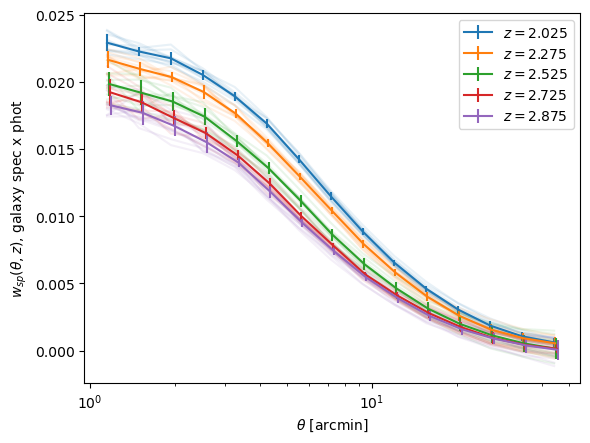

In [32]:
show_ind = [0, 5, 10, 14, 17]
for ii, ind in enumerate(show_ind):
    label=f"$z = {redshift_bincen[ind]}$"
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, wgsp_thetasplit_avg[0][:,ind], 
                 yerr=wgsp_thetasplit_avg[1][:,ind], color=f'C{ii}', label=label)
    for mm in range(10):
        plt.plot(theta_1_50_bincen, wgsp_thetasplit[mm][0][:,ind], color=f'C{ii}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, galaxy spec x phot")
plt.legend()

In [33]:
def wnotLimber_rsd_theta_galcross_lin(zmean, Delta_z, nz_law, theta_arcmin, beta_law, bias_law, zlim=[1.0,3.0]): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    This is for linear power spectrum!!
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=zlim[0]
    zmax1=zlim[1]

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd_lin(r,z1,mu,beta_law(z1, bias_law),beta2=beta_law(zmean+z2, bias_law))
            return old_output*nz_law(z1)*bias_law(z1)*bias_law(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [36]:
# work out theory fits to the measurements:
Dz=0.05
Ntheta=15

nz_law = nz_gal_law
beta_law = beta_law_gal
bias_law = bias_law_gal

Wgsp_theta150_dz05_rsd_lin=np.zeros((ntheta,Nbins))

for itheta in range(ntheta):
    #print(itheta)
    for kk, ind in enumerate(np.arange(Nbins)):
        theta = theta_1_50_bincen[itheta]
        zmean = redshift_bincen[ind]
        Wgsp_theta150_dz05_rsd_lin[itheta, kk] = wnotLimber_rsd_theta_galcross_lin(zmean, Dz, nz_law, theta, 
                                                    beta_law, 
                                                    bias_law)

Text(0, 1.8, '*Error bars are for mock avg')

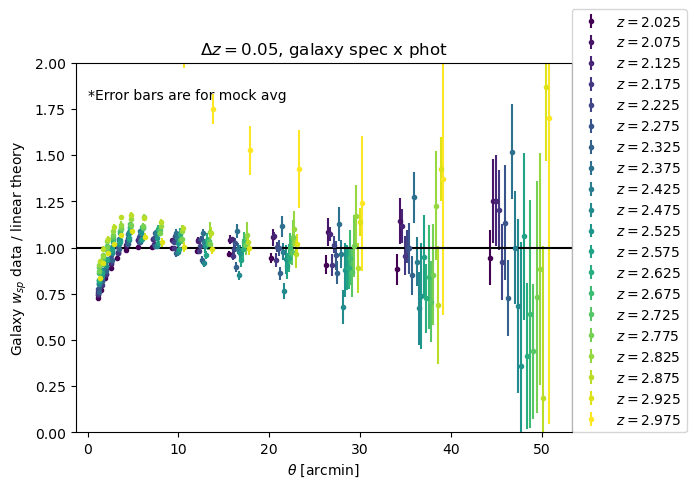

In [38]:
colors = plt.cm.viridis(np.linspace(0,1,20))
for kk, ind in enumerate(np.arange(Nbins)):
    #plt.plot(Theta_10_30_bincen, , color=colors[useind[ii]])
    y = wgsp_thetasplit_avg[0][:,ind]/Wgsp_theta150_dz05_rsd_lin[:,kk]
    dy =wgsp_thetasplit_avg[1][:,ind]/Wgsp_theta150_dz05_rsd_lin[:,kk]
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[ind],
                label=f"$z={redshift_bincen[ind]}$")
plt.axhline(1, color='k')
plt.ylabel("Galaxy $w_{sp}$ data / linear theory")
#plt.ylim([0,0.005])
#plt.xscale("log")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, galaxy spec x phot")
plt.ylim([0,2])
plt.text(0,1.8,"*Error bars are for mock avg")

# Sanity check: old galaxy n(z) i.e. no low z < 1.8


In [57]:
# load the measurements below:
wss_thetasplit={}
wpp_thetasplit={}
wsp_thetasplit={}
wsp_zbins_thetasplit={}

#! if downloaded from github, use root="data/"
for ii in range(10):
    root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
    root += f"run-{ii}/yaw-20bin/"
    fin = np.loadtxt(root + f"w_ss-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wss_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    fin = np.loadtxt(root + f"w_pp-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wpp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    fin = np.loadtxt(root + f"w_sp-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wsp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)
    
    #fin = np.loadtxt(root + f"w_sp-zbins-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    #wsp_zbins_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64, reverse_order=True)

In [58]:
# compute mock average
wss_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wpp_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wsp_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
#wsp_zbins_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))

holder = np.zeros((10, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))

for ii in range(10):
    holder[ii] = wss_thetasplit[ii][0]
wss_thetasplit_avg[0] = np.mean(holder,axis=0)
wss_thetasplit_avg[1] = np.std(holder,axis=0)
    
for ii in range(10):
    holder[ii] = wpp_thetasplit[ii][0]
wpp_thetasplit_avg[0] = np.mean(holder,axis=0)
wpp_thetasplit_avg[1] = np.std(holder,axis=0)

for ii in range(10):
    holder[ii] = wsp_thetasplit[ii][0]
wsp_thetasplit_avg[0] = np.mean(holder,axis=0)
wsp_thetasplit_avg[1] = np.std(holder,axis=0)

"""
for ii in range(10):
    holder[ii] = wsp_zbins_thetasplit[ii][0].T
wsp_zbins_thetasplit_avg[0] = np.mean(holder,axis=0)
wsp_zbins_thetasplit_avg[1] = np.std(holder,axis=0)
"""

'\nfor ii in range(10):\n    holder[ii] = wsp_zbins_thetasplit[ii][0].T\nwsp_zbins_thetasplit_avg[0] = np.mean(holder,axis=0)\nwsp_zbins_thetasplit_avg[1] = np.std(holder,axis=0)\n'

'\nplt.sca(axarr[1,1])\nfor kk, ind in enumerate(show_ind):\n    plt.errorbar(theta_1_50_bincen, wsp_zbins_thetasplit_avg[0][:,ind],yerr=wsp_zbins_thetasplit_avg[1][:,ind], color=f\'C{kk}\')\n    for ii in range(10):\n        plt.plot(theta_1_50_bincen, (wsp_zbins_thetasplit[ii][0].T)[:,ind], color=f\'C{kk}\', alpha=0.1)\nplt.xscale("log")\nplt.xlabel("$\\theta$ [arcmin]")\nplt.ylabel("$w_{sp}(\\theta, z)$, spec")\n#plt.ylim([-0.001,0])\n\nplt.tight_layout()\n'

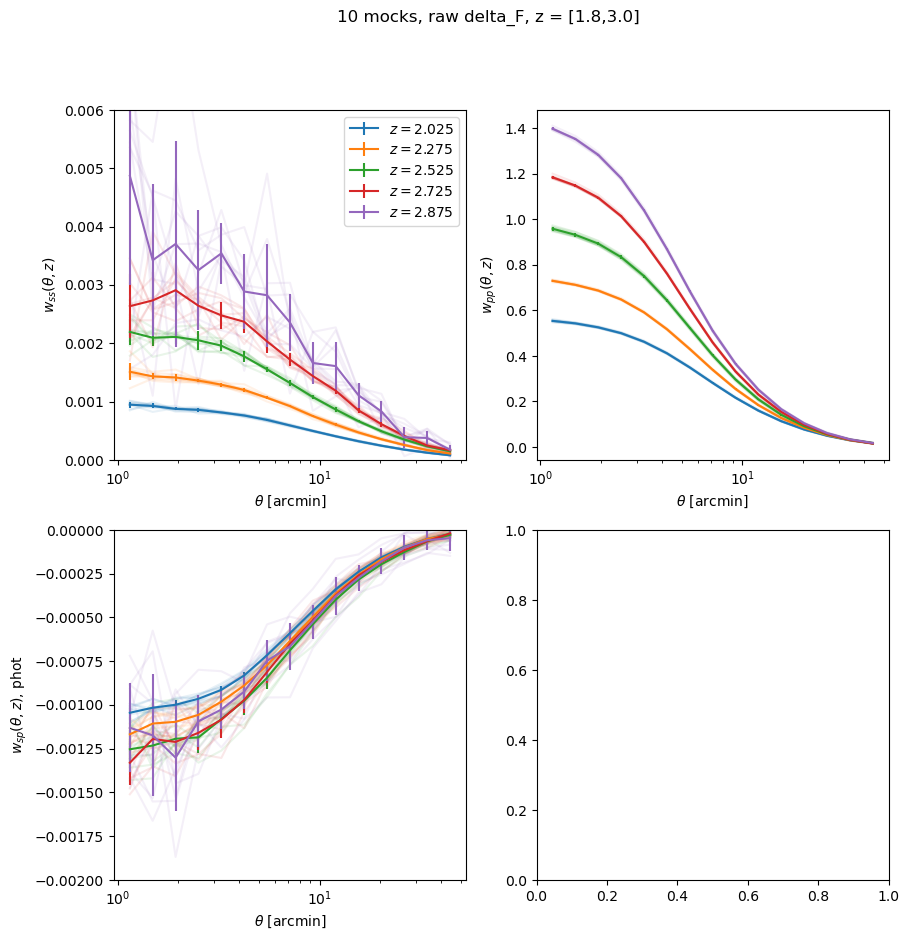

In [60]:
# show results:
show_ind = [0, 5, 10, 14, 17]

fig,axarr=plt.subplots(2,2,figsize=[10,10])

plt.suptitle("10 mocks, raw delta_F, $z_{\\rm unk} = [1.8,3.0]$")

plt.sca(axarr[0,0])
for kk, ind in enumerate(show_ind):
    label=f"$z = {redshift_bincen[ind]}$"
    plt.errorbar(theta_1_50_bincen, wss_thetasplit_avg[0][:,ind],yerr=wss_thetasplit_avg[1][:,ind], color=f'C{kk}',
                label=label)
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wss_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.ylim([0,0.006])
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{ss}(\\theta, z)$")
plt.legend()

plt.sca(axarr[0,1])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wpp_thetasplit_avg[0][:,ind],yerr=wpp_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wpp_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{pp}(\\theta, z)$")


plt.sca(axarr[1,0])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wsp_thetasplit_avg[0][:,ind],yerr=wsp_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, wsp_thetasplit[ii][0][:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, phot")
plt.ylim([-0.002,0])

"""
plt.sca(axarr[1,1])
for kk, ind in enumerate(show_ind):
    plt.errorbar(theta_1_50_bincen, wsp_zbins_thetasplit_avg[0][:,ind],yerr=wsp_zbins_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, (wsp_zbins_thetasplit[ii][0].T)[:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, spec")
#plt.ylim([-0.001,0])

plt.tight_layout()
"""

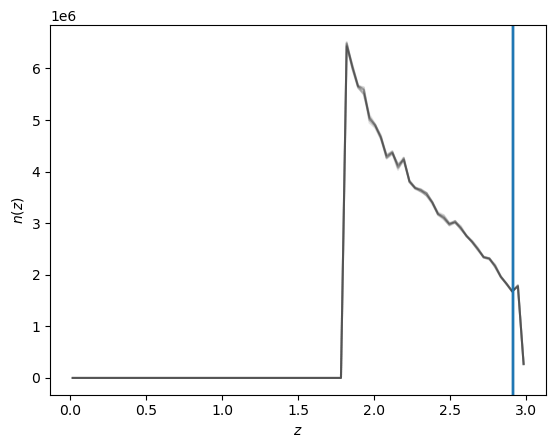

In [61]:
# get the nz_gal_law here:
root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"

nz_avg = 0
for ii in range(10):
    fname = root + f"run-{ii}/catalogue/nz-unknown-zmin-1.8-zmax-3.0.txt"
    fin = np.loadtxt(fname)
    plt.plot(fin[:,0],fin[:,1], alpha=0.1,color='k')
    nz_avg += fin[:,1]/10

    plt.axvline(2.91) # results above this redshift maybe weird
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
# let's get interpolation function
dz = fin[1,0]-fin[0,0]
nz_avg = nz_avg/sum(nz_avg)/dz
nz_zsamp = fin[:,0]
nz_gal_law = interpolate.interp1d(nz_zsamp,nz_avg,fill_value=0,bounds_error=False)

In [64]:
nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta150_dz05_rsd_lin_f=np.zeros((ntheta,Nbins))

for itheta in range(ntheta):
    print(itheta)
    for kk, ind in enumerate(np.arange(Nbins)):
        theta = theta_1_50_bincen[itheta]
        zmean = redshift_bincen[ind]
        Wsp_theta150_dz05_rsd_lin_f[itheta, kk] = wnotLimber_rsd_theta_cross_lin(zmean, Dz, nz_law, theta, 
                                                    beta_law1, 
                                                    beta_law2=beta_law2, bias_law1=bias_law1, 
                                                    bias_law2=bias_law2, zlim=[1.8,3.0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


(0.0, 2.0)

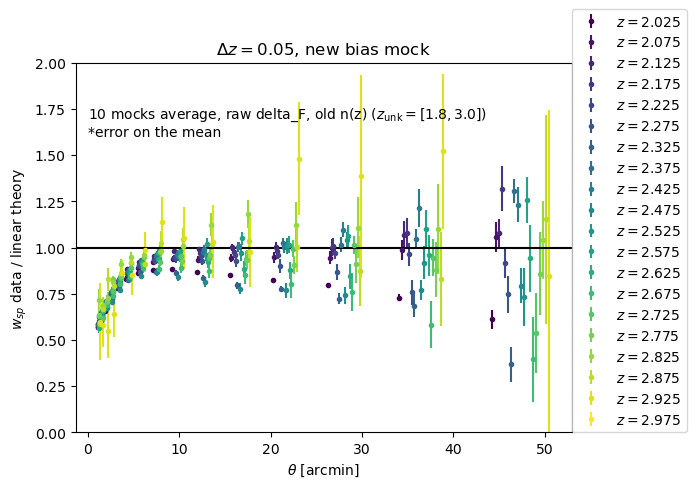

In [65]:
for kk in range(20):
    y = wsp_thetasplit_avg[0][:,kk]/Wsp_theta150_dz05_rsd_lin_f[:,kk]
    dy = abs(wsp_thetasplit_avg[1][:,kk]/Wsp_theta150_dz05_rsd_lin_f[:,kk])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[kk],
                label=f"$z={redshift_bincen[kk]}$")
plt.axhline(1, color='k')
plt.ylabel("$w_{sp}$ data / linear theory")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, new bias mock")
plt.text(0,1.7,"10 mocks average, raw delta_F, old n(z) ($z_{\\rm unk}=[1.8,3.0]$)")
plt.text(0,1.6,"*error on the mean")
plt.ylim([0,2])

# More sanity checks: cross redshift bin correlations:

In [39]:
# load the measurements below:
#wss_thetasplit={}
#wpp_thetasplit={}
#wsp_thetasplit={}
wsp_xzbins_thetasplit={}
wsp_xzbins_thetasplit_ex={}

#! if downloaded from github, use root="data/"
for ii in range(10):
    root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
    root += f"run-{ii}/yaw-20bin-SRD_nz/"
    #fin = np.loadtxt(root + f"w_ss-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    #wss_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    #fin = np.loadtxt(root + f"w_pp-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    #wpp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    #fin = np.loadtxt(root + f"w_sp-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    #wsp_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)
    
    fin = np.loadtxt(root + f"w_sp-cross-zbin-lya-z1-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")
    wsp_xzbins_thetasplit[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64, reverse_order=True)

    fin = np.loadtxt(root + f"w_sp-cross-zbin-lya-z1-raw-thetasplit-min-{theta_min}-max-{theta_max}-z12.txt")
    wsp_xzbins_thetasplit_ex[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, 16, njn=64, reverse_order=True)

In [43]:
# compute mock average
wsp_xzbins_thetasplit_avg = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
wsp_xzbins_thetasplit_avg_ex = np.zeros((2, (wss_thetasplit[ii][0]).shape[0], 16))

holder = np.zeros((10, (wss_thetasplit[ii][0]).shape[0], (wss_thetasplit[ii][0]).shape[1]))
for ii in range(10):
    holder[ii] = wsp_xzbins_thetasplit[ii][0].T
wsp_xzbins_thetasplit_avg[0] = np.mean(holder,axis=0)
wsp_xzbins_thetasplit_avg[1] = np.std(holder,axis=0)

holder = np.zeros((10, (wss_thetasplit[ii][0]).shape[0], 16))
for ii in range(10):
    holder[ii] = wsp_xzbins_thetasplit_ex[ii][0].T
wsp_xzbins_thetasplit_avg_ex[0] = np.mean(holder,axis=0)
wsp_xzbins_thetasplit_avg_ex[1] = np.std(holder,axis=0)

Text(0.5, 1.0, '$1<z<2$')

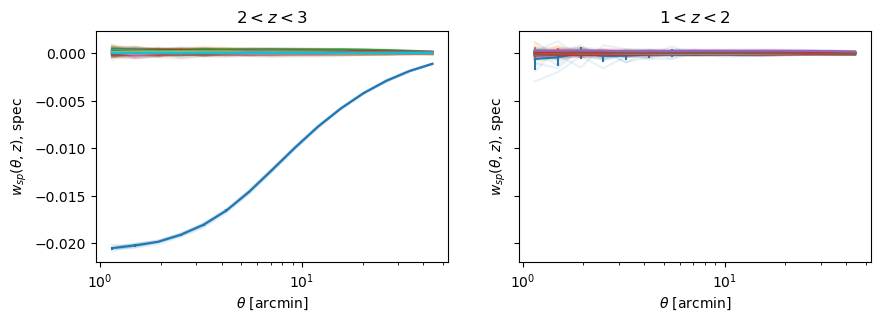

In [49]:
fig,axarr=plt.subplots(1,2,figsize=[10,3],sharey=True)
plt.sca(axarr[0])
# look at mock scatter:
for kk, ind in enumerate(np.arange(Nbins)):
    plt.errorbar(theta_1_50_bincen, wsp_xzbins_thetasplit_avg[0][:,ind],yerr=wsp_xzbins_thetasplit_avg[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, (wsp_xzbins_thetasplit[ii][0].T)[:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, spec")
plt.title("$2<z<3$")

plt.sca(axarr[1])
# look at mock scatter:
for kk, ind in enumerate(np.arange(16)):
    plt.errorbar(theta_1_50_bincen, wsp_xzbins_thetasplit_avg_ex[0][:,ind],yerr=wsp_xzbins_thetasplit_avg_ex[1][:,ind], color=f'C{kk}')
    for ii in range(10):
        plt.plot(theta_1_50_bincen, (wsp_xzbins_thetasplit_ex[ii][0].T)[:,ind], color=f'C{kk}', alpha=0.1)
plt.xscale("log")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$, spec")
plt.title("$1<z<2$")

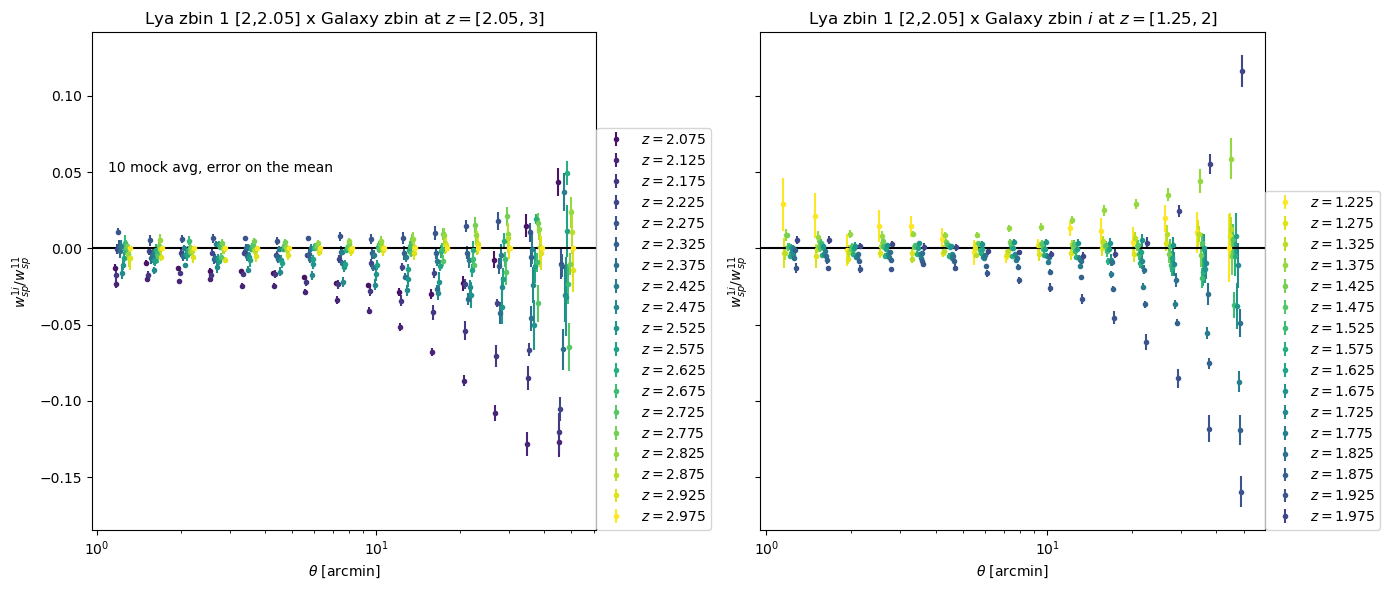

In [65]:
fig,axarr=plt.subplots(1,2,figsize=[14,6],sharey=True)
plt.sca(axarr[0])
for ii in range(1,20):
    #y = (wsp_xzbins_thetasplit[0][0].T)[:,ii]/(wsp_xzbins_thetasplit[0][0].T)[:,0]
    #dy = abs((wsp_xzbins_thetasplit[0][1].T)[:,ii]/(wsp_xzbins_thetasplit[0][0].T)[:,0])
    y = wsp_xzbins_thetasplit_avg[0][:,ii]/wsp_xzbins_thetasplit_avg[0][:,0]
    dy = abs(wsp_xzbins_thetasplit_avg[1][:,ii]/wsp_xzbins_thetasplit_avg[0][:,0])
    
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, y,
                 yerr=dy/np.sqrt(10),
                 color=colors[ii],fmt='.',label=f"$z={redshift_bincen[ii]}$")
plt.xscale('log')
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w^{1i}_{sp} /w^{11}_{sp} $")
plt.title("Lya zbin 1 [2,2.05] x Galaxy zbin at $z=[2.05,3]$")
plt.text(1.1,0.05,"10 mock avg, error on the mean")
plt.legend(loc=[1,0])
plt.axhline(0,color='k')

plt.sca(axarr[1])
zbins = [1,2,Nbins]
edges = np.linspace(float(zbins[0]), float(zbins[1]), int(zbins[2])+1)
edges = edges[4:]
zsamp = (edges[1:] + edges[:-1])/2.
for ii in range(16):
    y = wsp_xzbins_thetasplit_avg_ex[0][:,ii]/wsp_xzbins_thetasplit_avg[0][:,0]
    dy = abs(wsp_xzbins_thetasplit_avg_ex[1][:,ii]/wsp_xzbins_thetasplit_avg[0][:,0])
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, y,
                 yerr=dy/np.sqrt(10),
                 color=colors[-(ii+1)],fmt='.',label=f"$z={round(zsamp[ii],3)}$")
plt.xscale('log')
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w^{1i}_{sp} /w^{11}_{sp} $")
plt.title("Lya zbin 1 [2,2.05] x Galaxy zbin $i$ at $z=[1.25,2]$")
#plt.text(1.1,0.05,"10 mock avg, error on the mean")
plt.legend(loc=[1,0])
plt.axhline(0,color='k')

plt.tight_layout()

# theory pipeline 2

In [53]:
yaw_tag="-20bin-SRD_nz"
outroot = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
sim_num=0
saveroot = outroot + f"run-{sim_num}/yaw{yaw_tag}/inference/"
model_root = saveroot + "model/"

# load model files:
model_prefix = "wsp_int_known_bg_linear_theta_1_50"
zgrid=np.loadtxt(model_root + f"{model_prefix}.zgrid.txt")
theta=np.loadtxt(model_root + f"{model_prefix}.theta.txt")
Nzbins=20
zbin_edges = np.linspace(2,3,Nzbins+1)
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2.

if Nzbins>=20:
    meanz = meanz[:-1] # let's exclude the last bin in >= 20 bin case as it is not well measured

wsp_int1=np.loadtxt(model_root + f"{model_prefix}.thetasplit_int.txt")
wsp_int1 = wsp_int1.reshape((len(zgrid),Nzbins,len(theta)))

#nz_file = np.loadtxt(args.true_nz_path)
#nz_gal_law = interpolate.interp1d(nz_file[:,0],nz_file[:,1],fill_value=0,bounds_error=False)

# do ths for each theta:
def wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim):
    """
    w_z_func: the function that computes the wsp at various z of the unknown sample
    nz_law_unk: unknown redshift distribution function
    zlim: integration limit of the function
    """
    
    zmin = zlim[0]
    zmax = zlim[1]
    
    def integrate_z2(z):
        return nz_law_unk(z)*w_z_func(z)
    
    return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

# define model and likelihood functions here:
zlim = [1.0,3.0]
model = np.zeros((Nzbins, len(theta)))

nz_law_unk = nz_gal_law

for kk, thetak in enumerate(theta):
    for jj, z_ref in enumerate(meanz):
        fw = wsp_int1[:,jj,kk]
        w_z_func = interpolate.interp1d(zgrid, fw)
        model[jj, kk] = wsp_full_rsd_intez2(w_z_func, nz_law_unk, zlim)

/tmp/ipykernel_1386814/2821397472.py:38: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


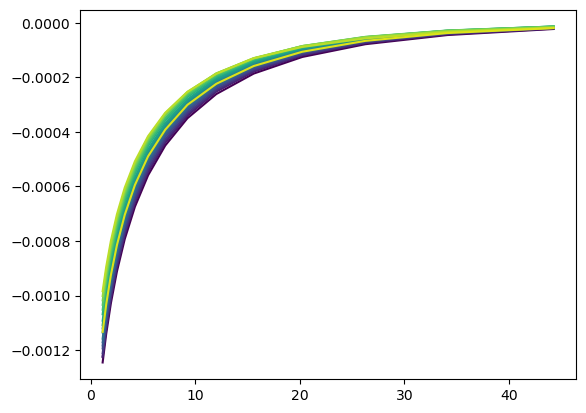

In [54]:
for ii in range(len(meanz)):
    plt.plot(theta, model[ii,:],color=colors[ii])

(0.0, 2.0)

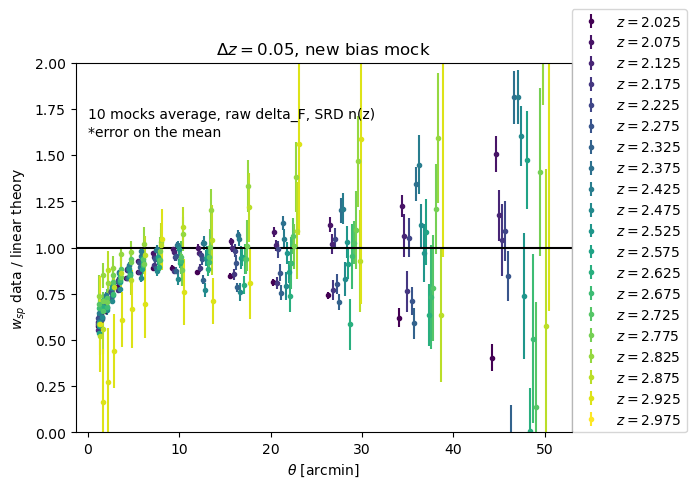

In [55]:
for kk in range(20):
    y = wsp_thetasplit_avg[0][:,kk]/model[kk,:]
    dy = abs(wsp_thetasplit_avg[1][:,kk]/model[kk,:])
    plt.errorbar(theta_1_50_bincen + kk*0.03*dTheta_1_50, y, yerr=dy/np.sqrt(10), fmt='.', color=colors[kk],
                label=f"$z={redshift_bincen[kk]}$")
plt.axhline(1, color='k')
plt.ylabel("$w_{sp}$ data / linear theory")
plt.legend(loc=[1,0])
plt.xlabel("$\\theta$ [arcmin]")
plt.title("$\\Delta z = 0.05$, new bias mock")
plt.text(0,1.7,"10 mocks average, raw delta_F, SRD n(z)")
plt.text(0,1.6,"*error on the mean")
plt.ylim([0,2])

# mean subtraction tests

Text(1, 0, 'jk. error')

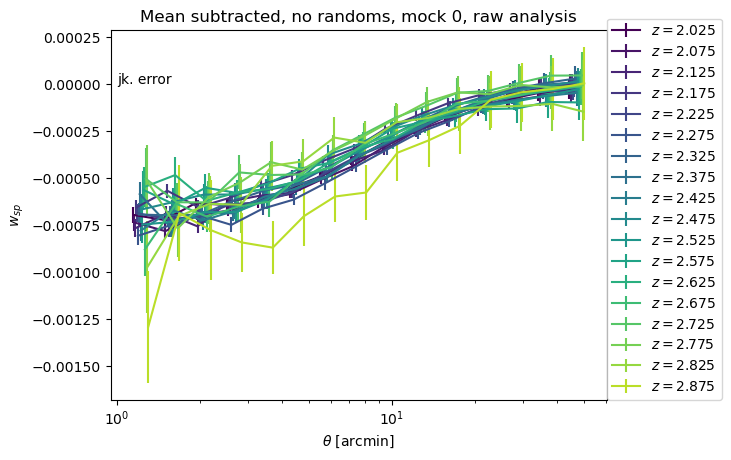

In [90]:
fin1 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin-SRD_nz/w_sp-raw-thetasplit-norand-theta-min-1-max-50.txt")

mean1,std1 = grab_mean_std_for_thetasplit_files(fin1, ntheta, Nbins, njn=64)

for ii in range(Nbins-2):
    label=f"$z={redshift_bincen[ii]}$"
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, mean1[:,ii], yerr=std1[:,ii],color=colors[ii],
                label=label)
plt.xscale("log")
plt.title("Mean subtracted, no randoms, mock 0, raw analysis")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}$")
plt.legend(loc=[1,0])
plt.text(1,0,"jk. error")

Text(1, 0.001, 'jk. error')

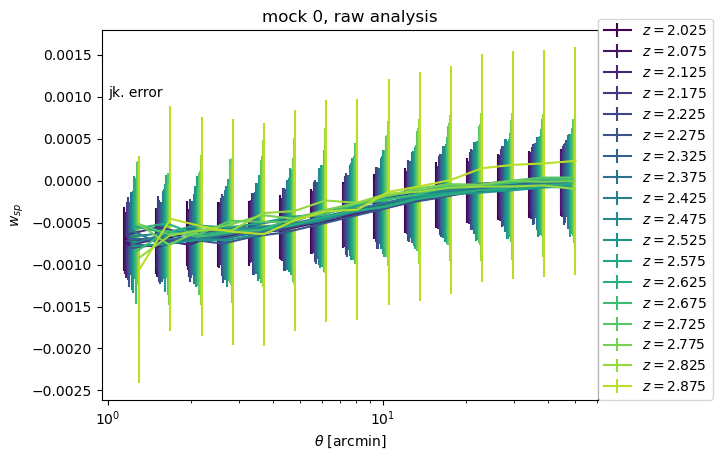

In [91]:
fin2 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin-SRD_nz/w_sp-raw-thetasplit-norand-theta-min-1-max-50.dd.txt")

mean2,std2 = grab_mean_std_for_thetasplit_files(fin2, ntheta, Nbins, njn=64)

for ii in range(Nbins-2):
    label=f"$z={redshift_bincen[ii]}$"
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, mean2[:,ii], yerr=std2[:,ii],color=colors[ii],
                label=label)
plt.xscale("log")
plt.title("mock 0, raw analysis")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}$")
plt.legend(loc=[1,0])
plt.text(1,0.001,"jk. error")

Text(1, 0.0, 'jk. error')

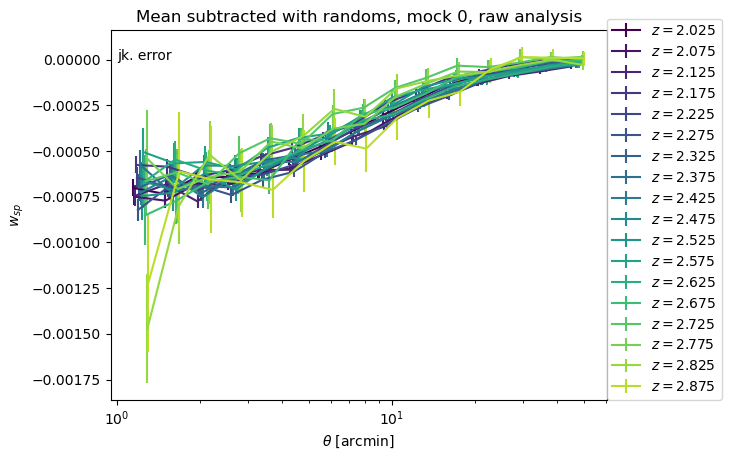

In [95]:
# comparison with old ver. with randoms:
fin3 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin-SRD_nz/w_sp-raw-thetasplit-min-1-max-50.txt")

mean3,std3 = grab_mean_std_for_thetasplit_files(fin3, ntheta, Nbins, njn=64)

for ii in range(Nbins-2):
    label=f"$z={redshift_bincen[ii]}$"
    plt.errorbar(theta_1_50_bincen + ii*0.03*dTheta_1_50, mean3[:,ii], yerr=std3[:,ii],color=colors[ii],
                label=label)
plt.xscale("log")
plt.title("Mean subtracted with randoms, mock 0, raw analysis")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}$")
plt.legend(loc=[1,0])
plt.text(1,0.,"jk. error")

Text(2, 0.0001, 'jk. average')

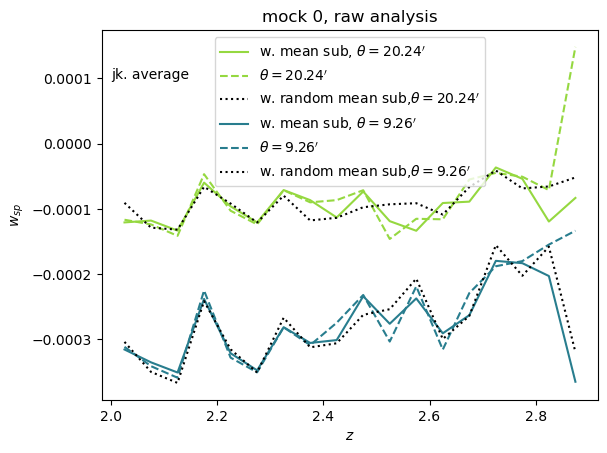

In [100]:
# pick a scale and plot w_sp as function of theta
theta_ind = -4
plt.errorbar(redshift_bincen[:-2], mean1[theta_ind,:-2], 
             label=f"w. mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind])#, yerr=std[theta_ind,:-2])
plt.errorbar(redshift_bincen[:-2], mean2[theta_ind,:-2], 
             label=f"$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], ls='--')
plt.errorbar(redshift_bincen[:-2], mean3[theta_ind,:-2], 
             label=f"w. random mean sub,$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color='k', ls=':')

theta_ind = 8
plt.errorbar(redshift_bincen[:-2], mean1[theta_ind,:-2],
            label=f"w. mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind])
plt.errorbar(redshift_bincen[:-2], mean2[theta_ind,:-2],
            label=f"$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], ls='--')
plt.errorbar(redshift_bincen[:-2], mean3[theta_ind,:-2], 
             label=f"w. random mean sub,$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color='k', ls=':')
plt.legend()
plt.xlabel("$z$")
plt.ylabel("$w_{sp}$")
plt.title("mock 0, raw analysis")
plt.text(2,0.0001,"jk. average")

### here show average for all mocks

In [104]:
# load the measurements below:
wsp_thetasplit_norand={}
wsp_thetasplit_norand_dd={}

#! if downloaded from github, use root="data/"
for ii in range(10):
    root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/"
    root += f"run-{ii}/yaw-20bin-SRD_nz/"

    fin = np.loadtxt(root + f"w_sp-raw-thetasplit-norand-theta-min-{theta_min}-max-{theta_max}.txt")
    wsp_thetasplit_norand[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

    fin = np.loadtxt(root + f"w_sp-raw-thetasplit-norand-theta-min-{theta_min}-max-{theta_max}.dd.txt")
    wsp_thetasplit_norand_dd[ii] = grab_mean_std_for_thetasplit_files(fin, ntheta, Nbins, njn=64)

In [109]:
# compute mock average
wsp_thetasplit_norand_avg = np.zeros((2, (wsp_thetasplit[ii][0]).shape[0], (wsp_thetasplit[ii][0]).shape[1]))
wsp_thetasplit_norand_dd_avg = np.zeros((2, (wsp_thetasplit[ii][0]).shape[0],  (wsp_thetasplit[ii][0]).shape[1]))

holder = np.zeros((10, (wsp_thetasplit[ii][0]).shape[0], (wsp_thetasplit[ii][0]).shape[1]))
for ii in range(10):
    holder[ii] = wsp_thetasplit_norand[ii][0]
wsp_thetasplit_norand_avg[0] = np.mean(holder,axis=0)
wsp_thetasplit_norand_avg[1] = np.std(holder,axis=0)


holder = np.zeros((10, (wsp_thetasplit[ii][0]).shape[0], (wsp_thetasplit[ii][0]).shape[1]))
for ii in range(10):
    holder[ii] = wsp_thetasplit_norand_dd[ii][0]
wsp_thetasplit_norand_dd_avg[0] = np.mean(holder,axis=0)
wsp_thetasplit_norand_dd_avg[1] = np.std(holder,axis=0)

w_{sp}^{ref}: w_sp with randoms; solid line: mean subtraction without randoms; dashed lines: no mean subtraction.


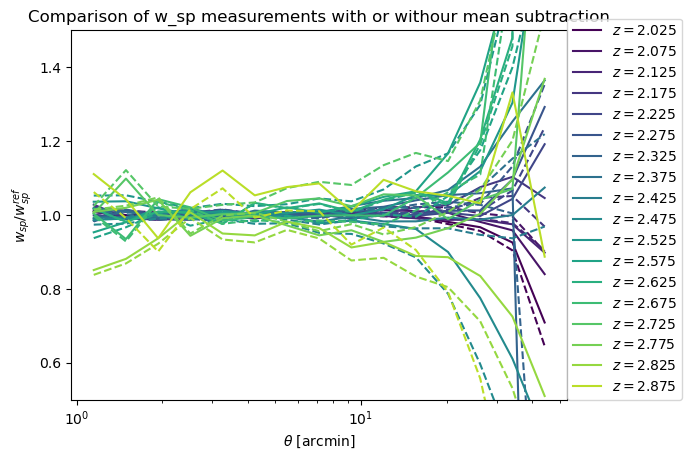

In [123]:
# we want to compare the difference between the two (and with wsp_thetasplit), and errorbars:
for ii in range(Nbins-2):
    label=f"$z={redshift_bincen[ii]}$"
    plt.plot(theta_1_50_bincen, wsp_thetasplit_norand_avg[0][:,ii]/wsp_thetasplit_avg[0][:,ii], 
             color=colors[ii],label=label)

    plt.plot(theta_1_50_bincen, wsp_thetasplit_norand_dd_avg[0][:,ii]/wsp_thetasplit_avg[0][:,ii], 
             color=colors[ii],ls='--')
plt.xscale("log")
plt.title("Comparison of w_sp measurements with or withour mean subtraction")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp} / w_{sp}^{ref}$")
plt.legend(loc=[1,0])
plt.ylim([0.5,1.5])
#plt.text(1,0,"jk. error")
print("w_{sp}^{ref}: w_sp with randoms; solid line: mean subtraction without randoms; dashed lines: no mean subtraction.")

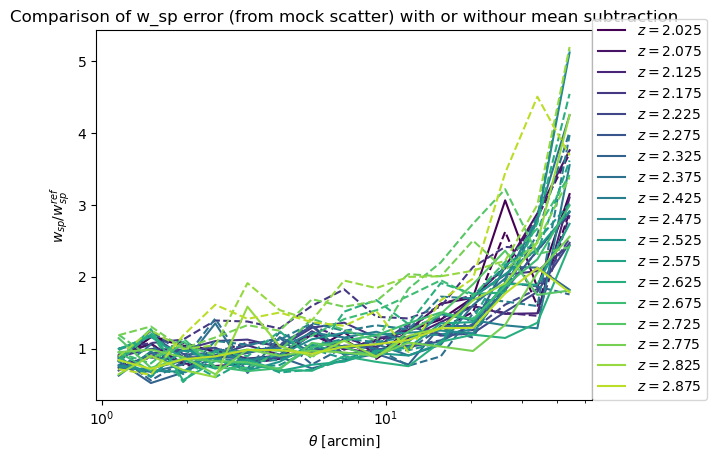

In [127]:
# we can also compare the error size:
for ii in range(Nbins-2):
    label=f"$z={redshift_bincen[ii]}$"
    plt.plot(theta_1_50_bincen, wsp_thetasplit_norand_avg[1][:,ii]/wsp_thetasplit_avg[1][:,ii], 
             color=colors[ii],label=label)

    plt.plot(theta_1_50_bincen, wsp_thetasplit_norand_dd_avg[1][:,ii]/wsp_thetasplit_avg[1][:,ii], 
             color=colors[ii],ls='--')
plt.xscale("log")
plt.title("Comparison of w_sp error (from mock scatter) with or withour mean subtraction")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp} / w_{sp}^{ref}$")
plt.legend(loc=[1,0])
#plt.ylim([0.5,1.5])

Text(0.5, 1.0, 'mock avg, raw analysis')

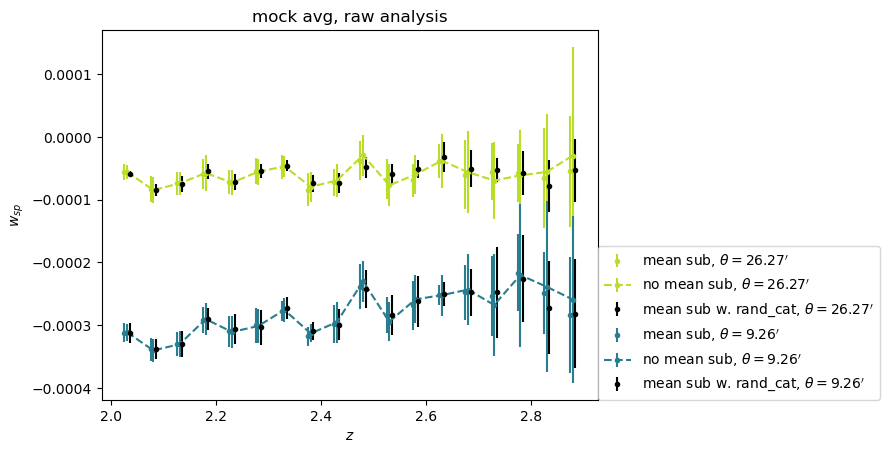

In [147]:
# look at a fixed theta:
# pick a scale and plot w_sp as function of theta
for theta_ind in [-3, 8]:

    plt.errorbar(redshift_bincen[:-2], wsp_thetasplit_norand_avg[0][theta_ind,:-2], yerr= wsp_thetasplit_norand_avg[1][theta_ind,:-2],
                 label=f"mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], fmt='.')
    plt.errorbar(redshift_bincen[:-2] + 0.005, wsp_thetasplit_norand_dd_avg[0][theta_ind,:-2], yerr= wsp_thetasplit_norand_dd_avg[1][theta_ind,:-2],
                 label=f"no mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], ls='--', fmt='.')
    plt.errorbar(redshift_bincen[:-2] + 0.01, wsp_thetasplit_avg[0][theta_ind,:-2], yerr= wsp_thetasplit_avg[1][theta_ind,:-2],
                 label=f"mean sub w. rand_cat, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color='k', fmt='.')


#plt.errorbar(redshift_bincen[:-2], mean1[theta_ind,:-2],
#            label=f"w. mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind])
#plt.errorbar(redshift_bincen[:-2], mean2[theta_ind,:-2],
#            label=f"$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], ls='--')
#plt.errorbar(redshift_bincen[:-2], mean3[theta_ind,:-2], 
#             label=f"w. random mean sub,$\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color='k', ls=':')
plt.legend(loc=[1,0])
plt.xlabel("$z$")
plt.ylabel("$w_{sp}$")
plt.title("mock avg, raw analysis")
#plt.text(2,0.0001,"jk. average")

In [153]:
error_rand=0
error_norand=0
error_norand_dd=0
for ii in range(10):
    error_rand += wsp_thetasplit[ii][1]/10
    error_norand += wsp_thetasplit_norand[ii][1]/10
    error_norand_dd += wsp_thetasplit_norand_dd[ii][1]/10

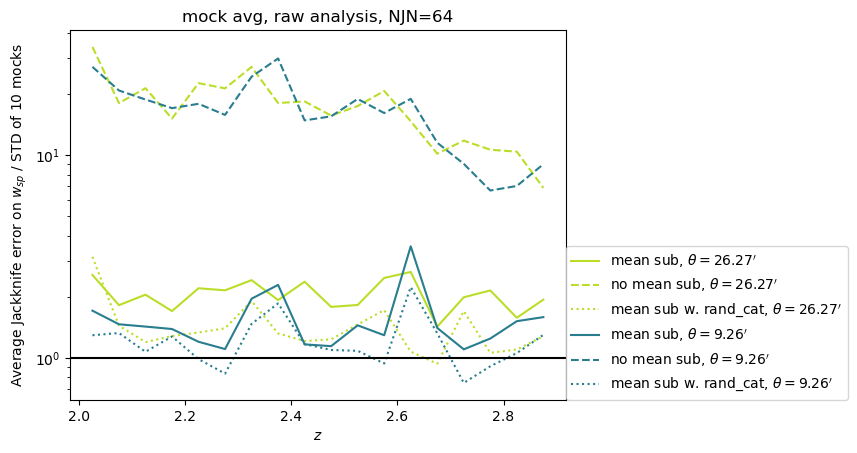

In [170]:
for theta_ind in [-3, 8]:
    plt.plot(redshift_bincen[:-2], error_norand[theta_ind,:-2] / wsp_thetasplit_norand_avg[1][theta_ind,:-2], 
            label=f"mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind])

    plt.plot(redshift_bincen[:-2], error_norand_dd[theta_ind,:-2] / wsp_thetasplit_norand_dd_avg[1][theta_ind,:-2], 
            label=f"no mean sub, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$", color=colors[theta_ind], ls='--')

    plt.plot(redshift_bincen[:-2], error_rand[theta_ind,:-2] / wsp_thetasplit_avg[1][theta_ind,:-2], 
            label=f"mean sub w. rand_cat, $\\theta={round(theta_1_50_bincen[theta_ind],2)}'$",
             color=colors[theta_ind],ls=':')

plt.legend(loc=[1,0])
plt.xlabel("$z$")
plt.ylabel("Average Jackknife error on $w_{sp}$ / STD of 10 mocks")
plt.title("mock avg, raw analysis, NJN=64")
plt.yscale("log")
plt.axhline(1,color='k')

<ErrorbarContainer object of 3 artists>

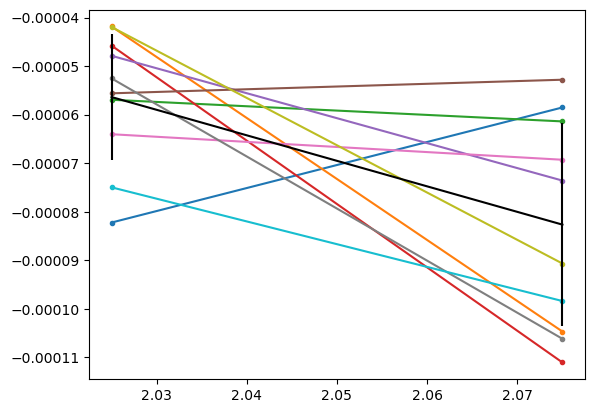

In [184]:
for ii in range(10):
    plt.plot(redshift_bincen[:2], wsp_thetasplit_norand[ii][0][-3,:2],'.-')
plt.errorbar(redshift_bincen[:2], wsp_thetasplit_norand_avg[0][-3,:2],yerr=wsp_thetasplit_norand_avg[1][-3,:2],
             color='k')

<ErrorbarContainer object of 3 artists>

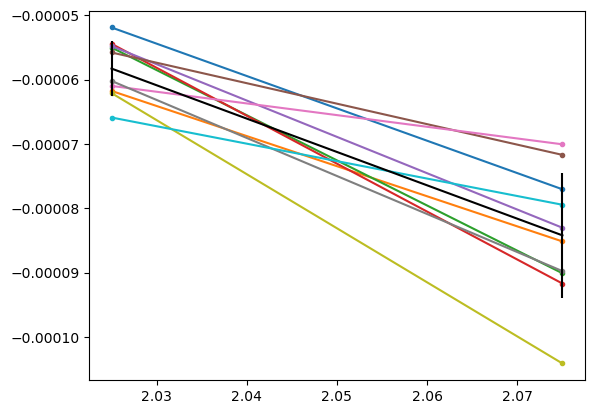

In [185]:
for ii in range(10):
    plt.plot(redshift_bincen[:2], wsp_thetasplit[ii][0][-3,:2],'.-')
plt.errorbar(redshift_bincen[:2], wsp_thetasplit_avg[0][-3,:2],yerr=wsp_thetasplit_avg[1][-3,:2],
             color='k')